# Сегментация изображений / Image segmentation

Лабораторная работа посвящена исследованию задачи сегментации на примере задачи предсказания маски для дорожного знака или разметки пешеходного перехода на фотографии.

При наличи вопросов по заданиям и для консультаций, можно писать на почту [vedyakov@itmo.ru](mailto:vedyakov@itmo.ru) или в телеграмме [@vedyakov](https://t.me/vedyakov).

**Общие требования**
1. Самостоятельность выполнения.
2. Обоснованность выводов.
3. Код должен быть запускаем, результаты воспроизводимы. Если данные берутся с вашего гугл-диска, то должна быть доступна ссылка на эти данные.
4. Colab Notebook должен содержать результаты выполнения кода в ячейках.
5. Общая структура данного Colab Notebook сохранена. Вы можете вводить дополнительные разделы, писать дополнительные функции, не кардинально менять разделы. Если убираете какой-то текст и прочее, проследите, что все результаты выполнения задач остаются явно отмечены.
6. Для сдачи задания ссылка на Colab Notebook должна быть отправлена через [Google Form](https://forms.gle/AFpnYMKw4kKb1rUF7). Если хотите продолжить работу, сделайте копию. Успели ли вы до дедлайна, будет проверяться по дате изменения ноутбука (изменять ноутбук после отправки нельзя).

**Дедлайны:**
- Мягкий – 26.03 23:59:59
- Жесткий – 29.03 23:59:59







## Задание. Решение задачи сегментации

Требуется предложить решение задачи бинарной сегментации изображения. Вы можете сами построить сеть, например, SegNet (80% баллов) или U-net (100% баллов), либо любую другую (100% баллов).

1. Нельзя
  - Использовать неслучайное разделение датасета на обучающую часть, валидационную и тестовую части.
  – Готовую или предобученную сеть.
2. Можно
  - Расширять (в примере используется 1000 изображений), аугментировать и преобразовывать входные данные, включая написание собственного класса [Dataset](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).
  - Менять количество эпох, [оптимизатор](https://pytorch.org/docs/stable/optim.html#algorithms), функцию потерь, использовать [scheduler'ы](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate) для изменения коэффициента скорости обучения (learning rate).
  - Все, что не запрещено.

**Требование:** среднее значение метрики IoU на тестовой части датасета не менее 0.65.

Задачи
0. Дополнить все недостающие части кода.
1. Подготовить датасет и даталоадеры, убедиться, что нормализация и преобразования прошли успешно.
2. Задать модель.
3. Написать функцию обучению, с выводом после каждой эпохи шести изображений, предсказанных масок и настоящих масок. Реализовать в функции обучения сохранение весов модели при обучении. Реализовать ячейки, где можно было бы не создавать модель, а загрузить предобученную, проверить её работу и продолжить обучение.
4. Обучить модель, построить графики значения метрик, функции потерь, проанализировать их и сделать выводы.
5. Визуализировать результат на тестовом датасете: вывести 6 случайных картинок (задавать номера нельзя), предсказанные маски, настоящие маски, значение метрики IoU между предсказанной и настоящей маской для каждого изображения.
6. Добавить аугментацию обучающего датасета. Сделать тестовый вывод 6 изображений из даталоадера.
7. Обучить новую модель (модель та же самая, что и выше, просто новый экземпляр) на аугментированных данных.
8. Сравнить результаты обучения модели на исходном датасете и на аугментированном. Для сравнения требуется настроить обучение в одинаковых условиях, при необходимости опишите обучение моделей для сравнения отдельно.

## Настройка среды / Environment setup

Импортируем необходимые модули.

Import required modules.

In [1]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

from torchvision import models, transforms
from torchsummary import summary

import time
import math
import random

from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import accuracy_score

import seaborn as sns
from matplotlib import colors, pyplot as plt
from matplotlib import rcParams
from IPython.display import clear_output

from tqdm import tqdm

%matplotlib inline
rcParams['figure.figsize'] = (15,4)
sns.set(style="darkgrid", font_scale=1.4)

Для воспроизводимости результатов зафиксируем параметры генераторов случайных чисел.

For reproducibility of the results, fix seed parameter in random number generators.

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

Для ускорения обучения может использоваться видеокарта. Для удобства создадим специальную переменную.

The GPU can be used to accelerate training. For convenience, let's create a special variable.

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

CPU = torch.device('cpu')

Посмотрим, доступно ли обучение на видеокарте.

Let us check that training on GPU is available.

In [ ]:
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

# Загрузка датасета

### Способ 1. По прямой ссылке / Way 1. By direct link

Используйте одну из ссылок / Use one of the links below
- https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0
- http://mlr.vedyakov.com/segmentation.zip

In [ ]:
# !wget -c http://mlr.vedyakov.com/segmentation.zip

После надо разархивировать.
Then we should unzip.

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# !unzip -q /content/drive/MyDrive/datasets_for_colab/segmentation.zip

### Cпособ 2. Cо своего гугл-диска / Way 2. From your google drive

Добавить на свой гугл-диск файл https://drive.google.com/file/d/1yqxfvTutEGOFMct5U_zVIP6e9v7R3AcL/view?usp=sharing
или скачать на компьютер по ссылкам https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0 или http://mlr.vedyakov.com/segmentation.zip после чего положить на свой гугл-диск.

В примере файл кладется в папку University/MLR

Add file to your personal google drive https://drive.google.com/file/d/1yqxfvTutEGOFMct5U_zVIP6e9v7R3AcL/view?usp=sharing
or download from direct link https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0 or http://mlr.vedyakov.com/segmentation.zip and upload to the personal google drive.

In the example, the file in the University/MLR directory.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
# !ls /content/gdrive/MyDrive/University/MLR


Если файл виден, то разархивируем его в текущую рабочую директорию

If file exists, then unzip it in the currect working directory.

In [ ]:
!unzip -q /content/gdrive/MyDrive/datasets_for_colab/segmentation.zip

# Задача 1. Подготовка датасета

Посмотрим на датасет дорожных фотографий и при необходимости подготовим его для обучения.

Let's take a look at the dataset of road photos and prepare it for training if necessary.

In [ ]:
X = np.load('./x_train.npy')
Y = np.load('./y_train.npy')

print(X.shape)
print(Y.shape)

(3083, 256, 256, 3)
(3083, 256, 256, 1)


Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

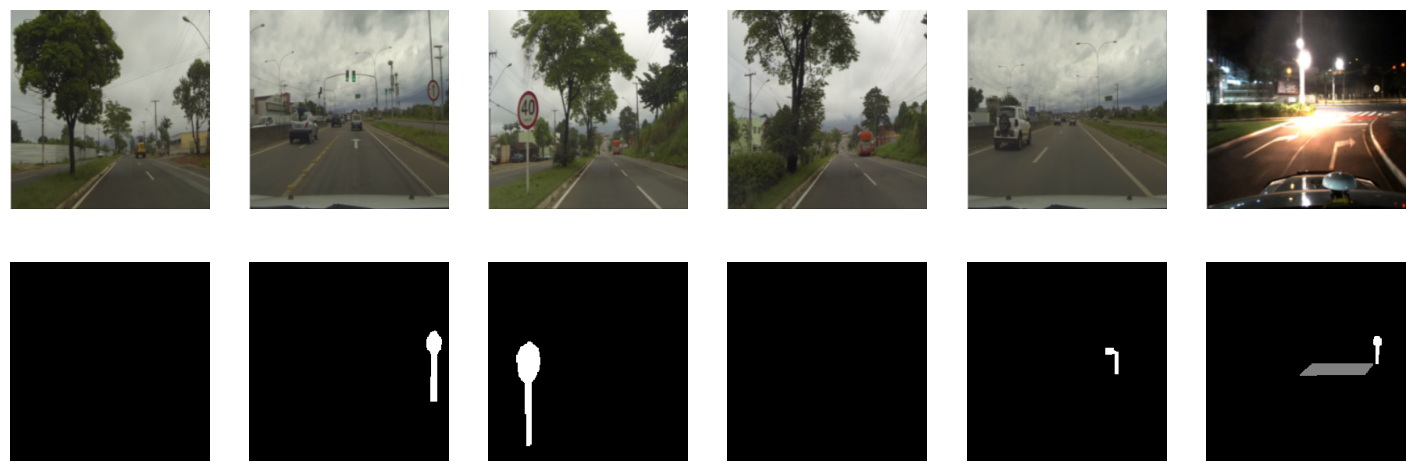

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = 100+i*10;
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[j])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[j].squeeze(), cmap='gray')
plt.show();

In [ ]:
XX = np.transpose(X[0:3000:3], axes=(0, 3, 1, 2))
YY = np.transpose(Y[0:3000:3], axes=(0, 3, 1, 2))

print(XX.shape)
print(YY.shape)

(1000, 3, 256, 256)
(1000, 1, 256, 256)


Проверим какие значения присутствуют в маске

In [ ]:
unique, counts = np.unique(YY, return_counts=True)
print(unique, counts)

[0 1 2] [62570586  2697615   267799]


В ней присутствуют следующие значения

*   0 – фон
*   1 – дорожный знак
*   2 – разметка пешеходного перехода

Мы будем решать задачу бинарной сегментации, т.е. делать одну маску и на дорожные знаки, для этого надо сделать так, чтобы вместо значения 2 стояло значение 1.


In [ ]:
YY = np.clip(YY, 0, 1)# your code here

Проверим какие теперь значения присутствуют в маске. Приэтом количество нулей не должно измениться, а количество «единиц» должно быть равно сумме количества единиц и двоек в масках до преобразования.

In [ ]:
unique, counts = np.unique(YY, return_counts=True)
print(unique, counts)

[0 1] [62570586  2965414]


Переведем значения пикселей изображения в диапазон [0;1]

In [ ]:
XXX = np.array(XX / 255, dtype='float32')
YYY = np.array(YY, dtype='float32')

print(XXX.shape)
print(YYY.shape)

(1000, 3, 256, 256)
(1000, 1, 256, 256)


Нормализуем значения пикселей

In [ ]:
X_t = torch.FloatTensor(XXX)
Y_t = torch.FloatTensor(YYY)

for x in X_t:
  transforms.functional.normalize(x, (0.485, 0.456, 0.406), (0.229, 0.224, 0.225), inplace=True)

print(X_t.shape)
print(X_t[0])

torch.Size([1000, 3, 256, 256])
tensor([[[ 1.5297,  1.0673,  0.9474,  ...,  1.2385,  1.1872,  0.8618],
         [ 1.8379,  1.3242,  1.1872,  ...,  1.4783,  1.4440,  1.1700],
         [ 1.8379,  1.3242,  1.1872,  ...,  1.4612,  1.4783,  1.2214],
         ...,
         [ 1.8379, -0.2171, -1.1075,  ..., -1.0219, -1.0390, -1.1418],
         [ 1.8379, -0.2171, -1.1247,  ..., -1.0562, -1.0733, -1.1760],
         [ 1.5297, -0.4054, -1.2788,  ..., -1.2445, -1.2445, -1.3302]],

        [[ 1.6933,  1.2556,  1.1506,  ...,  1.4482,  1.3957,  1.0455],
         [ 2.0084,  1.5357,  1.4132,  ...,  1.6933,  1.6583,  1.3782],
         [ 2.0084,  1.5357,  1.4132,  ...,  1.6758,  1.6933,  1.4132],
         ...,
         [ 2.0084, -0.0749, -0.9678,  ..., -0.9328, -0.9503, -1.0553],
         [ 2.0084, -0.0749, -0.9853,  ..., -0.9678, -0.9853, -1.0903],
         [ 1.6933, -0.2850, -1.1604,  ..., -1.1604, -1.1604, -1.2479]],

        [[ 1.9080,  1.4200,  1.2980,  ...,  1.5594,  1.4897,  1.1585],
         [ 2.

Разделим наши 1000 картинок на 700/150/150
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(XX), len(XX), False)
tr, val, ts = np.split(ix, [700, 850])

In [ ]:
print(len(tr), len(val), len(ts))

700 150 150


Создадим даталоадеры

In [ ]:
X_train_t = X_t[tr]
Y_train_t = Y_t[tr]
X_val_t = X_t[val]
Y_val_t = Y_t[val]
X_test_t = X_t[ts]
Y_test_t = Y_t[ts]

train_dataset = TensorDataset(X_train_t, Y_train_t)
val_dataset = TensorDataset(X_val_t, Y_val_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
loaders = {
    'train': train_dataloader,
    'valid': val_dataloader
}

-----

Ниже функция для вывода картинок, который были нормализованы и хранятся в тензорах.

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Выведите одну из картинок после нормализации, чтобы убедиться, что все хорошо

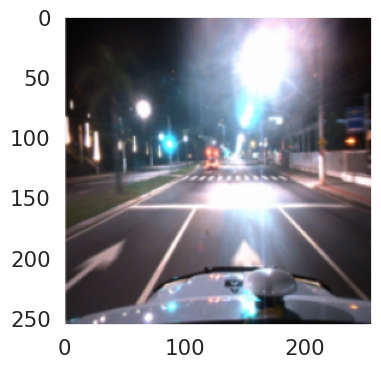

In [ ]:
img1 = next(iter(train_dataloader))[0][0]

imshow(img1)

# Задача 2. Задание модели



Здесь вы должны сами построить сеть, например, SegNet (80% баллов) или U-net (100% баллов), либо любую другую (100% баллов).

In [ ]:
class UNet(nn.Module):

  def __init__(self, input_channels, output_channels):
      super().__init__()

      #downsampling
      self.convol1 = nn.Sequential(
          nn.Conv2d(input_channels, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU()
      )
      self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.convol2 = nn.Sequential(
          nn.Conv2d(64, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU()
      )
      self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.convol3 = nn.Sequential(
          nn.Conv2d(128, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU()
      )
      self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.convol4 = nn.Sequential(
          nn.Conv2d(256, 512, kernel_size=3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU()
      )

      self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

      self.convol_down = nn.Sequential(
          nn.Conv2d(512, 1024, kernel_size=3, padding=1),
          nn.BatchNorm2d(1024),
          nn.ReLU(),
          nn.Conv2d(1024, 1024, kernel_size=3, padding=1),
          nn.BatchNorm2d(1024),
          nn.ReLU()
      )

      #upsampling
      self.upconv_down = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)

      self.dec4 = nn.Sequential(
          nn.Conv2d(1024, 512, kernel_size=3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU(),
          nn.Conv2d(512, 512, kernel_size=3, padding=1),
          nn.BatchNorm2d(512),
          nn.ReLU()
      )
      self.upconv4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)

      self.dec3 = nn.Sequential(
          nn.Conv2d(512, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU(),
          nn.Conv2d(256, 256, kernel_size=3, padding=1),
          nn.BatchNorm2d(256),
          nn.ReLU()
      )

      self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)

      self.dec2 = nn.Sequential(
          nn.Conv2d(256, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU(),
          nn.Conv2d(128, 128, kernel_size=3, padding=1),
          nn.BatchNorm2d(128),
          nn.ReLU()
      )

      self.upconv2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

      self.dec1 = nn.Sequential(
          nn.Conv2d(128, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU(),
          nn.Conv2d(64, 64, kernel_size=3, padding=1),
          nn.BatchNorm2d(64),
          nn.ReLU()
      )

      self.conv_out = nn.ConvTranspose2d(64, output_channels, kernel_size=1)

  def forward(self, X):

      enc1 = self.convol1(X)
      enc2 = self.convol2(self.maxpool1(enc1))
      enc3 = self.convol3(self.maxpool2(enc2))
      enc4 = self.convol4(self.maxpool3(enc3))

      bottom = self.convol_down(self.maxpool4(enc4))
      bottom = self.upconv_down(bottom)

      dec4 = torch.cat((enc4, bottom), axis=1)
      dec4 = self.dec4(dec4)
      dec4 = self.upconv4(dec4)

      dec3 = torch.cat((enc3, dec4), axis=1)
      dec3 = self.dec3(dec3)
      dec3 = self.upconv3(dec3)

      dec2 = torch.cat((enc2, dec3), axis=1)
      dec2 = self.dec2(dec2)
      dec2 = self.upconv2(dec2)

      dec1 = torch.cat((enc1, dec2), axis=1)
      dec1 = self.dec1(dec1)
      y = self.conv_out(dec1)

      return y

model = UNet(input_channels=3, output_channels=1)

# print(model)

In [ ]:
next(iter(train_dataloader))[1].shape

torch.Size([32, 1, 256, 256])

## Метрика

В качестве метрики будем использовать отношения пересечения (intersection) масок к их объединению (union), подробнее можно почитать по
[ссылке](https://www.jeremyjordan.me/evaluating-image-segmentation-models/).

Метрика согласно определению рассчитывается по формуле
$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$



![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

Чтобы избежать деления на 0, в числительно и знаменатель добавляется малое положительное число.

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8

    intersection = (outputs & labels).sum((1, 2))
    union = (outputs | labels).sum((1, 2))

    iou = (intersection + SMOOTH)/(union + SMOOTH)

    return iou

Проверим работу функции

In [ ]:
outputs = torch.FloatTensor([[[1., 0.], [0., 1.]], [[1., 0.], [0., 1.]]])
oposite = torch.FloatTensor([[[0., 1.], [1., 0.]], [[0., 1.], [1., 0.]]])
intersected = torch.FloatTensor([[[1., 1.], [0., 1.]], [[1., 1.], [0., 1.]]])

print('iou_pytorch(outputs, outputs)', iou_pytorch(outputs, outputs).mean().item())
print('iou_pytorch(oposite, oposite)', iou_pytorch(oposite, oposite).mean().item())
print('iou_pytorch(intersected, intersected)', iou_pytorch(intersected, intersected).mean().item())

print('iou_pytorch(outputs, oposite)', iou_pytorch(outputs, oposite).mean().item())
print('iou_pytorch(outputs, intersected)', iou_pytorch(outputs, intersected).mean().item())
print('iou_pytorch(oposite, intersected)', iou_pytorch(oposite, intersected).mean().item())

iou_pytorch(outputs, outputs) 1.0
iou_pytorch(oposite, oposite) 1.0
iou_pytorch(intersected, intersected) 1.0
iou_pytorch(outputs, oposite) 2.4999999848063226e-09
iou_pytorch(outputs, intersected) 0.6666666865348816
iou_pytorch(oposite, intersected) 0.25


# Задача 3. Реализация функции обучения

Написать функцию обучению, выводящую после каждой эпохи шести изображений валидационного датасета, предсказанных масок и настоящих масок, значения метрики и функции потерь.

In [ ]:
def plot_example(X_batch, Y_batch, Y_pred, title):

    clear_output(wait=True)
    plt.rcParams["figure.figsize"] = (15,8)

    for k in range(6):
        i = np.random.randint(0, X_batch.shape[0])
        plt.subplot(3, 6, k+1)
        plt.imshow(np.rollaxis(X_batch[i].numpy(), 0, 3))
        plt.title('Photo')
        plt.axis('off')

        if Y_batch is not None:
            plt.subplot(3, 6, k+7)
            plt.imshow(Y_batch[i, 0], cmap='gray')
            plt.title('Mask')
            plt.axis('off')

        if Y_pred is not None:
            plt.subplot(3, 6, k+13)
            plt.imshow(Y_pred[i, 0], cmap='gray')
            plt.title('Prediction')
            plt.axis('off')

    plt.suptitle(title)
    plt.show()


In [ ]:
def train(name, model, optimizer, loss_fn, metric_fn, epochs, loaders):
    losses = {"train": [], "valid": []}
    scores = {"train": [], "valid": []}

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        for stage, dataloader in loaders.items():
            avg_loss = 0
            avg_score = 0

            if stage == 'train':
                model.train()
            else:
                model.eval()

            for X_batch, Y_batch in dataloader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                if stage == 'train':
                    optimizer.zero_grad()

                    logits = model(X_batch)
                    loss = loss_fn(logits, Y_batch)

                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        logits = model(X_batch)
                        loss = loss_fn(logits, Y_batch)

                # calculate score and loss to show the user
                Y_pred = torch.round(torch.sigmoid(logits.detach()))
                score = metric_fn(Y_pred.cpu(), Y_batch.cpu()).mean().item()

                avg_loss += loss.detach().cpu().numpy() / len(dataloader)
                avg_score += score / len(dataloader)


                # clean GPU memory
                X_batch = X_batch.cpu()
                Y_batch = Y_batch.cpu()
                logits = logits.cpu()
                Y_pred = Y_pred.cpu()
                torch.cuda.empty_cache()


            losses[stage].append(avg_loss)
            scores[stage].append(avg_score)

        # scheduler.step(avg_loss)

        if stage == 'valid':
              plot_example(X_batch, Y_batch, Y_pred, f"epoch {epoch +1}/{epochs}, avg_loss = {avg_loss}, avg_score {avg_score}")

    return losses, scores

In [ ]:
def train2(name, model, optimizer, loss_fn, metric_fn, epochs, dataloader):
    # without testing on validation

    losses = []
    scores = []

    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))
        avg_loss = 0
        avg_score = 0

        model.train()

        for X_batch, Y_batch in dataloader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)


            optimizer.zero_grad()
            logits = model(X_batch)
            loss = loss_fn(logits, Y_batch)
            loss.backward()
            optimizer.step()


            # calculate score and loss to show the user
            Y_pred = torch.round(torch.sigmoid(logits.detach()))
            score = metric_fn(Y_pred.cpu(), Y_batch.cpu()).mean().item()

            avg_loss += loss.detach().cpu().numpy() / len(dataloader)
            avg_score += score / len(dataloader)


            # clean GPU memory
            X_batch = X_batch.cpu()
            Y_batch = Y_batch.cpu()
            logits = logits.cpu()
            Y_pred = Y_pred.cpu()
            torch.cuda.empty_cache()


        losses.append(avg_loss)
        scores.append(avg_score)

        # scheduler.step(avg_loss)

        plot_example(X_batch, Y_batch, Y_pred, f"epoch {epoch +1}/{epochs}, avg_loss = {avg_loss}, avg_score {avg_score}")

    return losses, scores

In [ ]:
def train_sch(name, model, optimizer, loss_fn, metric_fn, epochs, loaders, scheduler):
    # with scheduler
    losses = {"train": [], "valid": []}
    scores = {"train": [], "valid": []}


    for epoch in range(epochs):
        print('* Epoch %d/%d' % (epoch+1, epochs))

        for stage, dataloader in loaders.items():
            avg_loss = 0
            avg_score = 0

            if stage == 'train':
                model.train()
            else:
                model.eval()

            for X_batch, Y_batch in dataloader:
                X_batch = X_batch.to(device)
                Y_batch = Y_batch.to(device)

                if stage == 'train':
                    optimizer.zero_grad()

                    logits = model(X_batch)
                    loss = loss_fn(logits, Y_batch)

                    loss.backward()
                    optimizer.step()
                else:
                    with torch.no_grad():
                        logits = model(X_batch)
                        loss = loss_fn(logits, Y_batch)
                        #scheduler
                        scheduler.step(loss)


                # calculate score and loss to show the user
                Y_pred = torch.round(torch.sigmoid(logits.detach()))
                score = metric_fn(Y_pred.cpu(), Y_batch.cpu()).mean().item()

                avg_loss += loss.detach().cpu().numpy() / len(dataloader)
                avg_score += score / len(dataloader)

                # clean GPU memory
                X_batch = X_batch.cpu()
                Y_batch = Y_batch.cpu()
                logits = logits.cpu()
                Y_pred = Y_pred.cpu()
                torch.cuda.empty_cache()


            losses[stage].append(avg_loss)
            scores[stage].append(avg_score)

        # scheduler.step(avg_loss)

        if stage == 'valid':
              plot_example(X_batch, Y_batch, Y_pred, f"epoch {epoch +1}/{epochs}, avg_loss = {avg_loss}, avg_score {avg_score}")

    return losses, scores

# Задача 4. Обучение

In [ ]:
def plot_losses_scores(losses, scores):
  figure, axis = plt.subplots(1, 2, figsize=(12, 8))
  axis = axis.flatten()

  axis[0].plot(range(len(losses["train"])), losses["train"], label='Train')
  axis[0].plot(range(len(losses["valid"])), losses["valid"], label='valid')
  axis[0].set_title('Losses')
  axis[0].set_xlabel("Iteration")
  axis[0].set_ylabel("Loss")
  axis[0].legend()

  axis[1].plot(range(len(scores["train"])), scores["train"], label='Train')
  axis[1].plot(range(len(scores["valid"])), scores["valid"], label='valid')
  axis[1].set_title('Scores')
  axis[1].set_xlabel("Iteration")
  axis[1].set_ylabel("Score")
  axis[1].legend()

  plt.show()

def plot_losses_scores2(losses, scores):
  # for training without testing on validation
  figure, axis = plt.subplots(1, 2, figsize=(12, 8))
  axis = axis.flatten()

  axis[0].plot(range(len(losses)), losses, label='Train')
  axis[0].set_title('Losses')
  axis[0].set_xlabel("Iteration")
  axis[0].set_ylabel("Loss")
  axis[0].legend()

  axis[1].plot(range(len(scores)), scores, label='Train')
  axis[1].set_title('Scores')
  axis[1].set_xlabel("Iteration")
  axis[1].set_ylabel("Score")
  axis[1].legend()

  plt.show()

In [ ]:
def predict_eval_on_batch(model, X_batch, device = device):
    model.eval()
    model.to(device)

    with torch.no_grad():
        if X_batch.device != device:
            X_batch = X_batch.to(device)

        logits = model(X_batch).detach()
        Y_pred = torch.round(torch.sigmoid(logits))

        if device != CPU:
            X_batch = X_batch.cpu()
            Y_pred = Y_pred.cpu()
            logtis = logits.cpu()

    return Y_pred, logits

def predict(model, dataloader, device = device):
    Y_preds = []

    for X_batch, _ in dataloader:
        Y_pred, _ = predict_eval_on_batch(model, X_batch, device)
        Y_preds.append(Y_pred)

    return np.array(torch.cat(Y_preds))

def score_mode(model, metric, dataloader, device):
    score = 0
    for X_batch, Y_label in dataloader:
        Y_pred, _ = predict_eval_on_batch(model, X_batch, device)
        score += metric(Y_pred, Y_label).mean().item() / len(dataloader)

    return score

Обучите модель

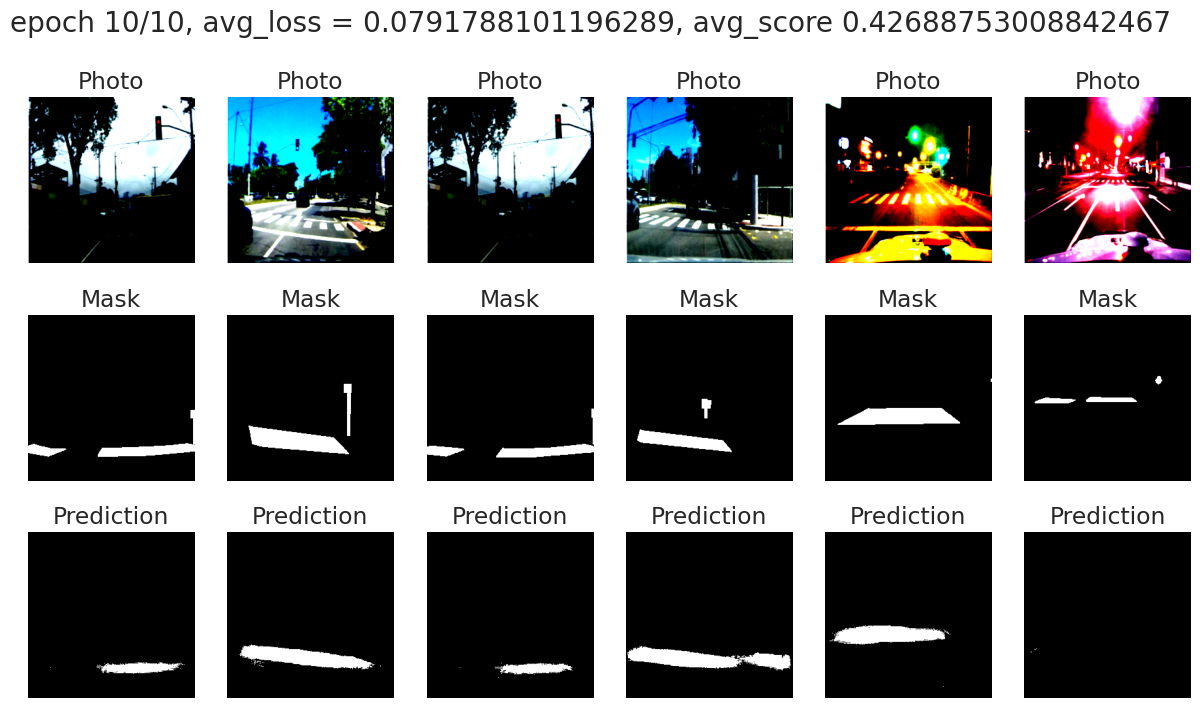

In [ ]:
model = UNet(input_channels=3, output_channels=1).to(device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)

max_epochs = 10

losses1, scores1 = train("UNet", model, optimizer, loss_fn, iou_pytorch, max_epochs, loaders)

Построим графики значения метрики и функции потерь

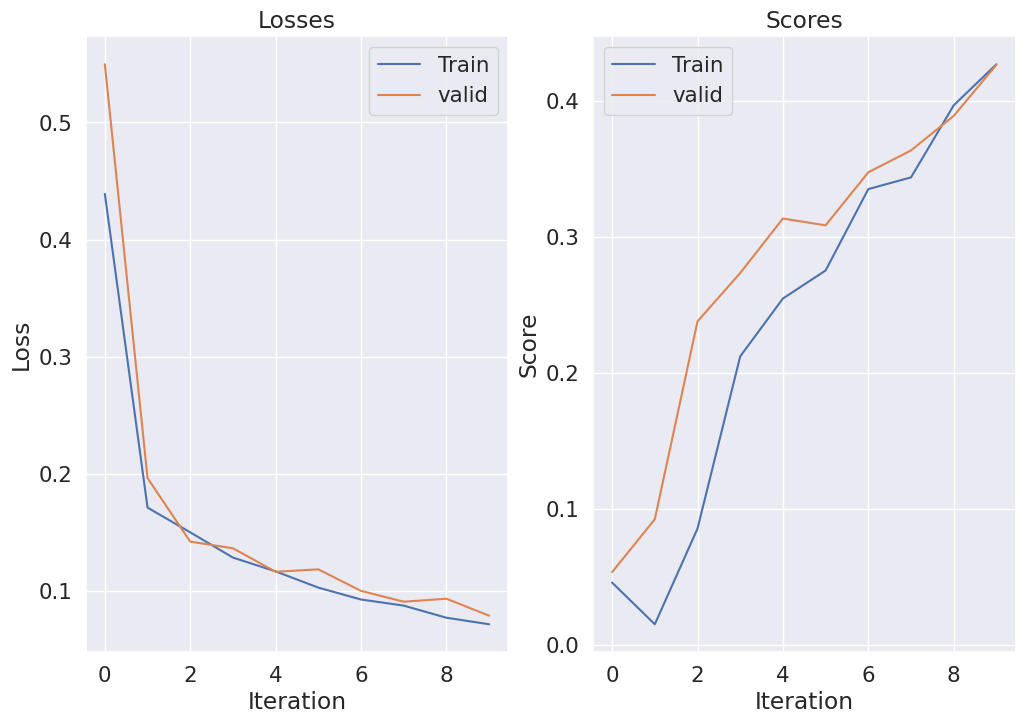

In [ ]:
plot_losses_scores(losses1, scores1)

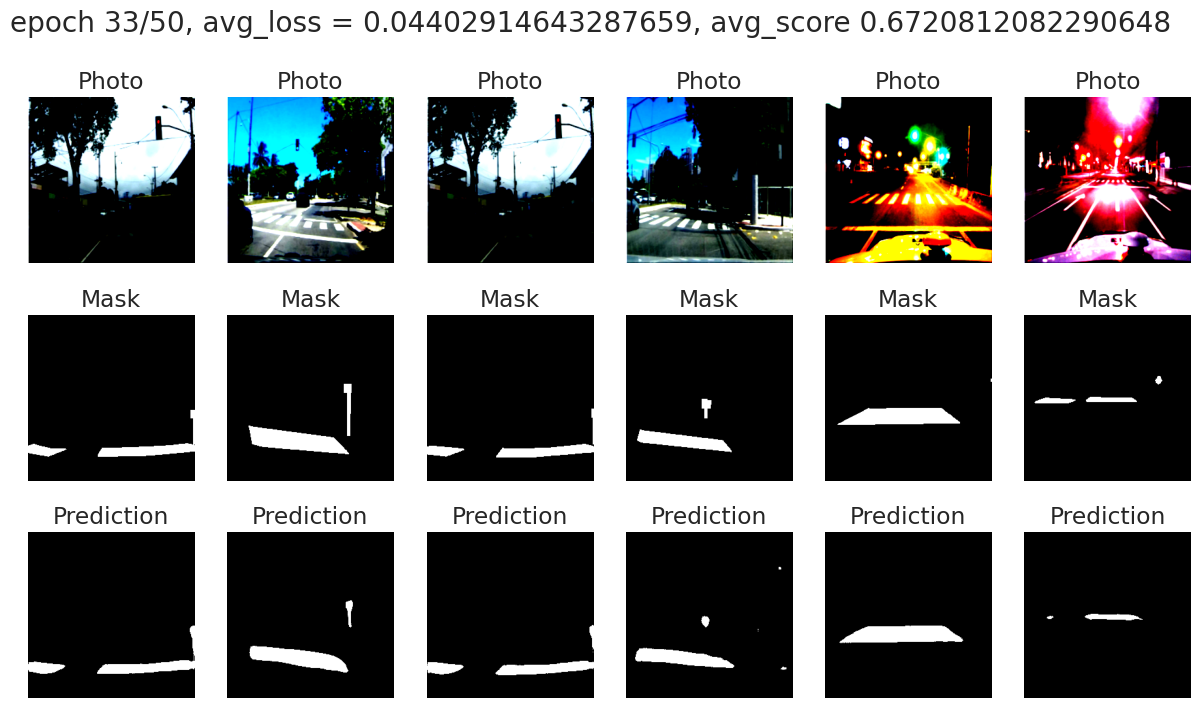

* Epoch 34/50


KeyboardInterrupt: 

In [ ]:
max_epochs = 50
optimizer2 = torch.optim.Adam(model.parameters(), lr = 1e-4)

losses2, scores2 = train("UNet", model, optimizer2, loss_fn, iou_pytorch, max_epochs, loaders)

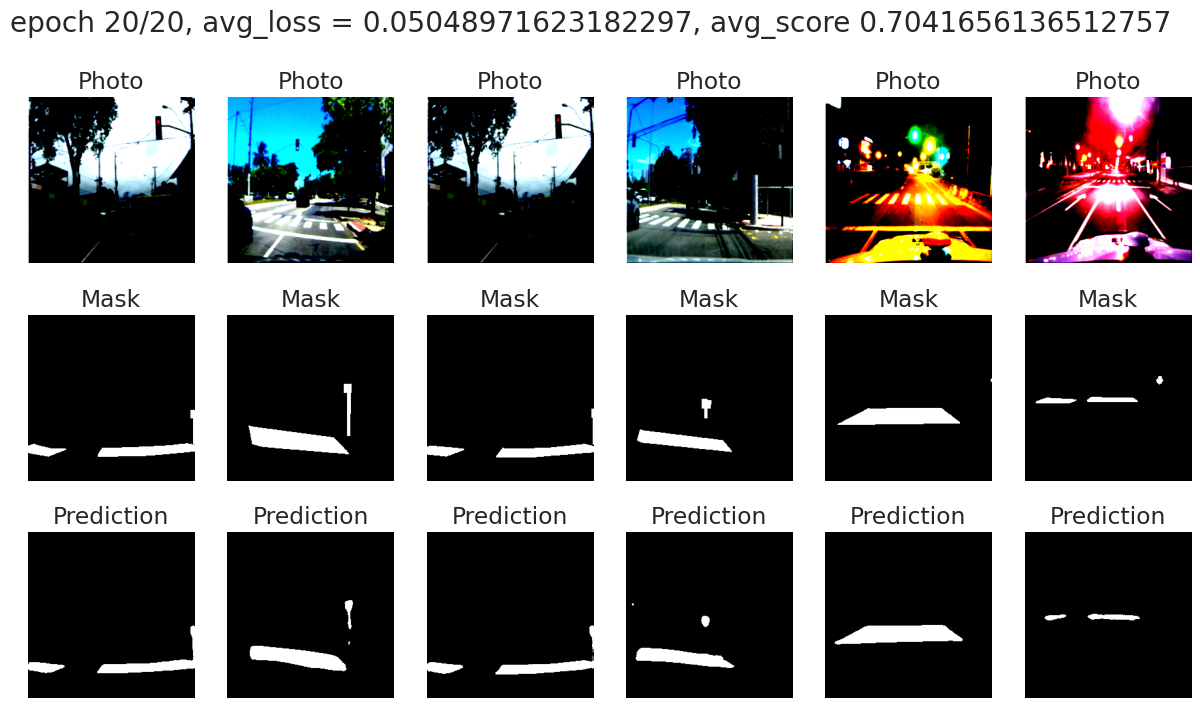

In [ ]:
max_epochs = 20
optimizer3 = torch.optim.Adam(model.parameters(), lr = 1e-6)

losses3, scores3 = train("UNet", model, optimizer3, loss_fn, iou_pytorch, max_epochs, loaders)

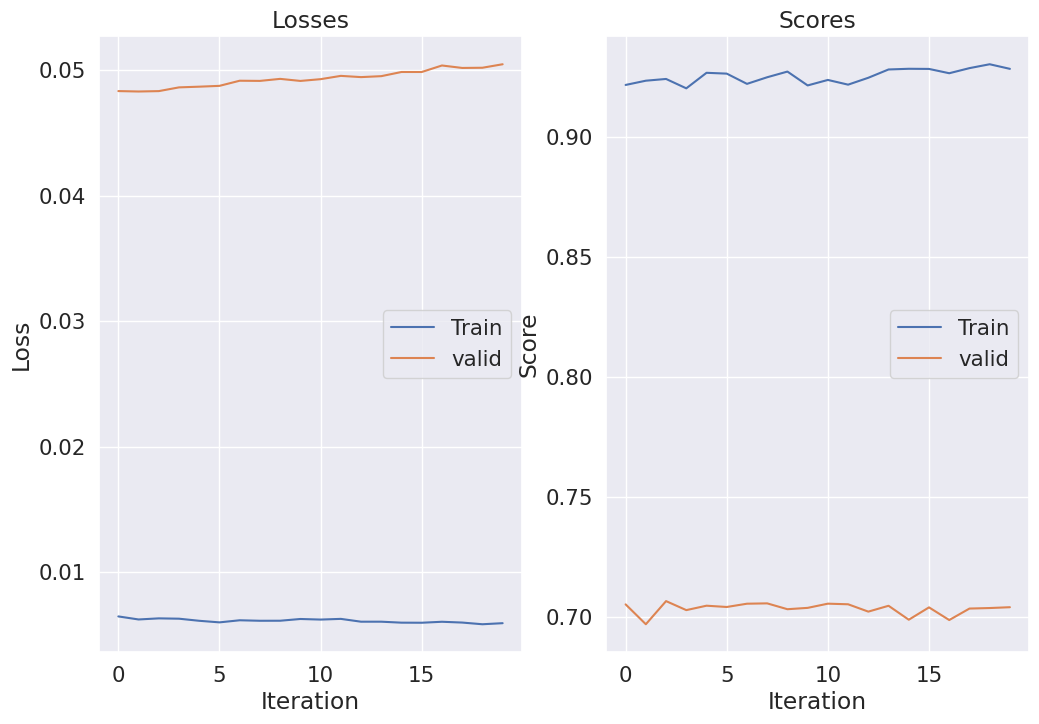

In [ ]:
plot_losses_scores(losses3, scores3)

Рассчитайте значение метркии IoU на обучающием, валидационном и тестовом датасетах, проанализируйте их значения.

In [ ]:
score_mode(model, iou_pytorch, train_dataloader, device)

0.9356830851598219

In [ ]:
score_mode(model, iou_pytorch, val_dataloader, device)

0.7041656136512757

In [ ]:
score_mode(model, iou_pytorch, test_dataloader, device)

0.6257184624671936

Что можно сказать? (напишите вывод)

Модель успешно обучается. Но возможно нужно еще понизить lr

In [ ]:
torch.save(model.state_dict(), '/content/model.pth')


# Задача 5. Визуализация результатов

Визуализируйте результаты на тестовом датасете: выведите 6 случайных картинок (задавать номера нельзя), в заголовке каждой из них выведите настоящую метку класса и предсказанную.

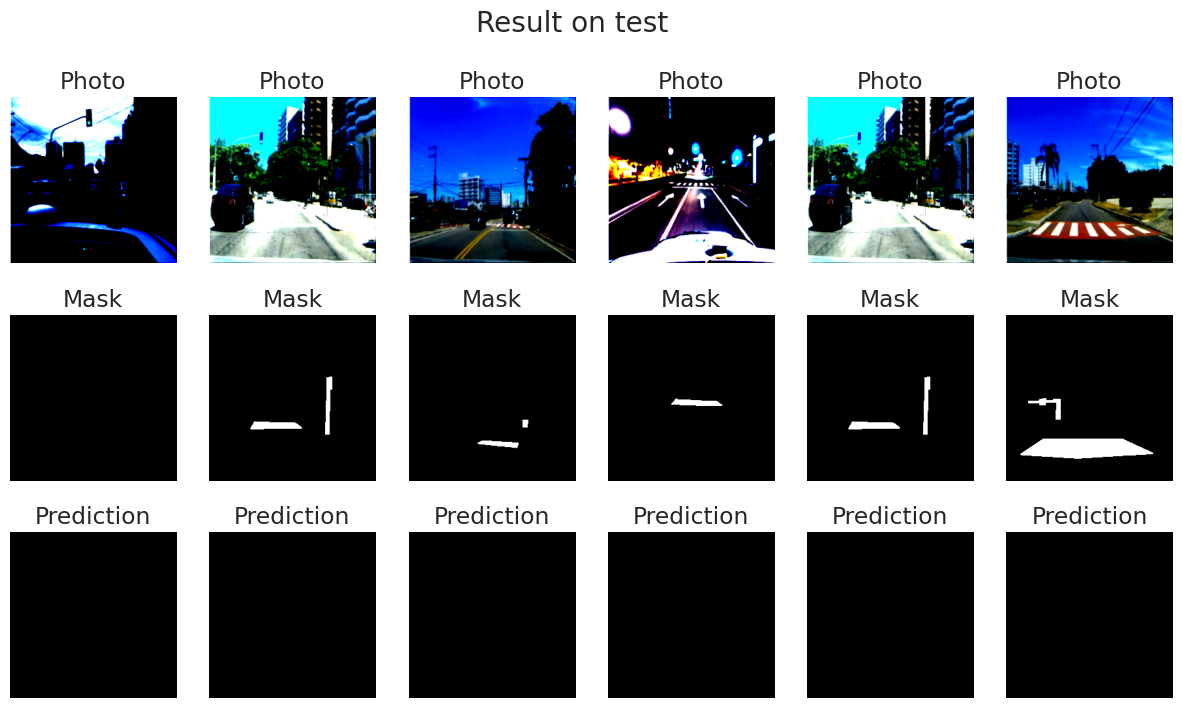

In [ ]:
X_test_batch, Y_test_batch = next(iter(test_dataloader))
Y_test_pred, _ = predict_eval_on_batch(model, X_test_batch, device)

plot_example(X_test_batch, Y_test_batch, Y_test_pred, 'Result on test')

# Задача 6. Аугментация данных

Требуется использовать не менее двух трансформаций

In [ ]:
X_batch2, Y_batch2 = next(iter(train_dataloader))

In [ ]:
from torchvision.transforms import Compose, v2 # https://pytorch.org/vision/stable/transforms.html
import torchvision.transforms as T
from torchvision import tv_tensors


class OurOwnDataset(Dataset):
    def __init__(self, data, masks, transforms=None):
        self.data = data
        self.masks = masks
        self.transforms = transforms

        print(f'Found {len(self.data)} items')

    def __getitem__(self, i):
        image = self.data[i]
        mask = self.masks[i]

        image_mask = torch.cat([image, mask], dim=0)

        if self.transforms:
            image = self.transforms(image)

        return image_mask[:3,:,:], image_mask[3:,:,:]

    def __len__(self):
        return len(self.data)

In [ ]:
getitem_transforms4 = Compose(
    [
        # v2.ToImage(),
        # T.RandomAdjustSharpness(sharpness_factor=2),
        # T.ColorJitter(brightness=.5, hue=.3),
        # T.RandomInvert(),
        T.RandomHorizontalFlip(p=1),
        # T.RandomPosterize(bits=2),
        T.RandomResizedCrop(size=(128, 128)),
        T.RandomRotation(degrees=(-15, 15)),
        # T.ElasticTransform(alpha=250.0),
        # v2.ToDtype(torch.float32, scale=True),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

train_dataset_augmented4 = OurOwnDataset(X_train_t, Y_train_t, transforms=getitem_transforms4)
train_dataloader_augmented4 = DataLoader(train_dataset_augmented4, batch_size=32, shuffle=True)

Found 700 items


In [ ]:
aug_loaders4 = {
    'train': train_dataloader_augmented4,
    'valid': val_dataloader
}

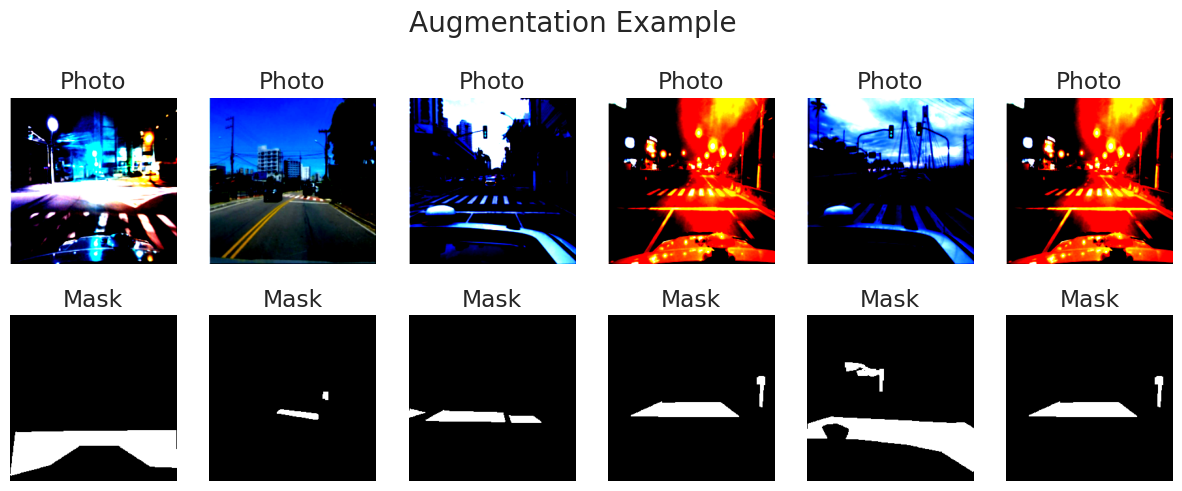

In [ ]:
X_batch1, Y_batch1 = next(iter(train_dataloader_augmented4))

plot_example(X_batch1, Y_batch1, None, 'Augmentation Example')

In [ ]:
class CustomDatasetAugmented(Dataset):
    def __init__(self, data, mode):
        super().__init__()
        # режим работы
        self.mode = mode

        self.data = data

        self.len_ = len(data)

        # Создадим трансформации
        if self.mode == 'train':
            self.transformBefore = transforms.Compose([
                SameRandomTransformation
            ])

        self.transformAfter = transforms.Compose([
            # TODO
        ])

    def __len__(self):
        return self.len_

    def __getitem__(self, index):

        # ...

# Задача 7. Обучение новой модели


In [ ]:
model2 = UNet(input_channels=3, output_channels=1).to(device)
loss_fn_aug = nn.BCEWithLogitsLoss()
optimizer_aug = torch.optim.Adam(model2.parameters(), lr=1e-4)

max_epochs2 = 20

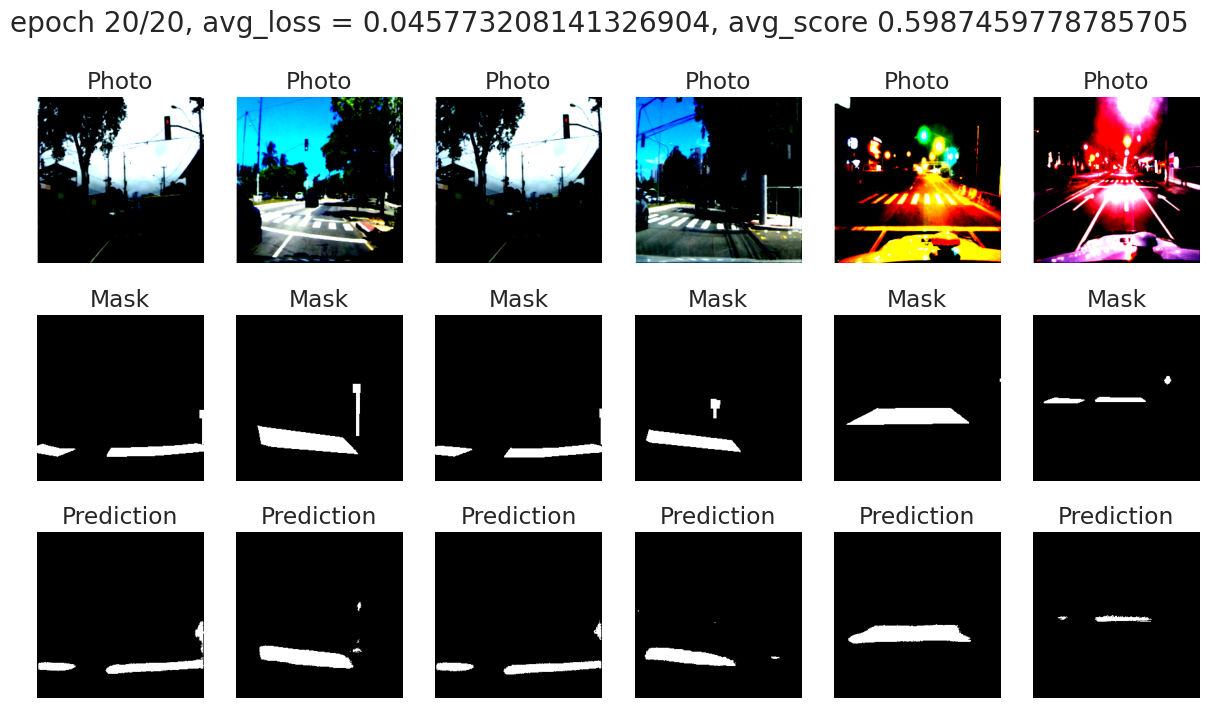

In [ ]:
losses1_aug, scores1_aug = train("Unet_augm", model2, optimizer_aug, loss_fn_aug, iou_pytorch, max_epochs2, aug_loaders)


In [ ]:
torch.save(model2.state_dict(), '/content/model2.pth')

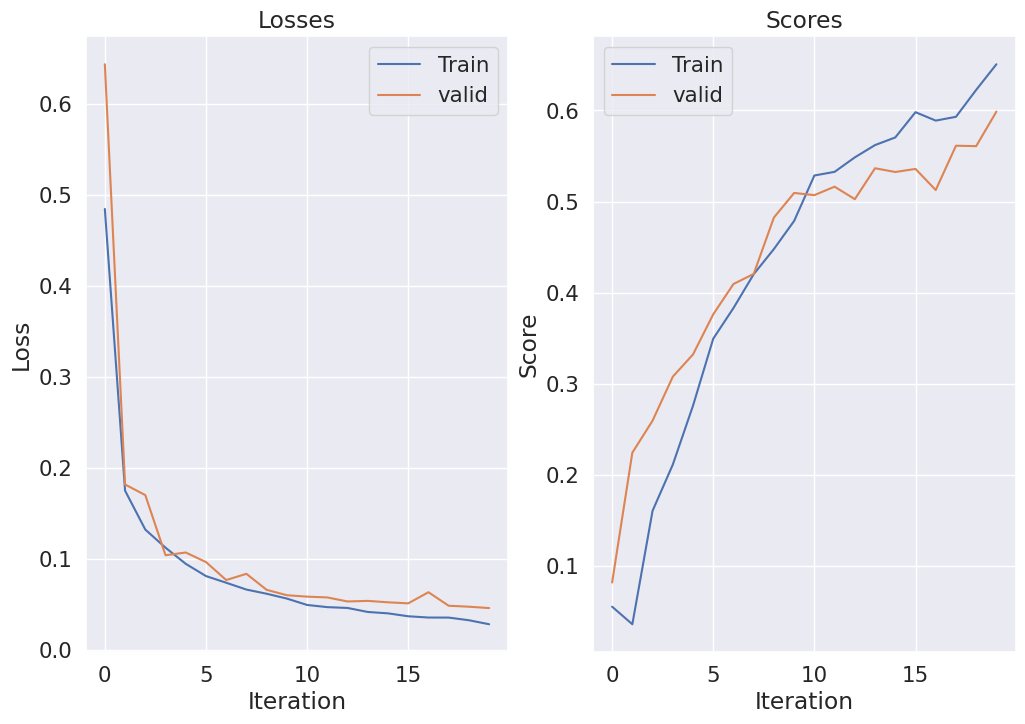

In [ ]:
plot_losses_scores(losses1_aug, scores1_aug)


In [ ]:
print("Score train", score_mode(model2, iou_pytorch, train_dataloader, device))
print("Score val", score_mode(model2, iou_pytorch, val_dataloader, device))
print("Score test", score_mode(model2, iou_pytorch, test_dataloader, device))

Score train 0.7078790285370566
Score val 0.5987459778785705
Score test 0.5140120089054108


In [ ]:
model3 = UNet(input_channels=3, output_channels=1).to(device)
loss_fn_aug3 = nn.BCEWithLogitsLoss()
optimizer_aug3 = torch.optim.Adam(model3.parameters(), lr=1e-4)

max_epochs2 = 20

In [ ]:
model3.load_state_dict(torch.load('/content/model.pth'))

<All keys matched successfully>

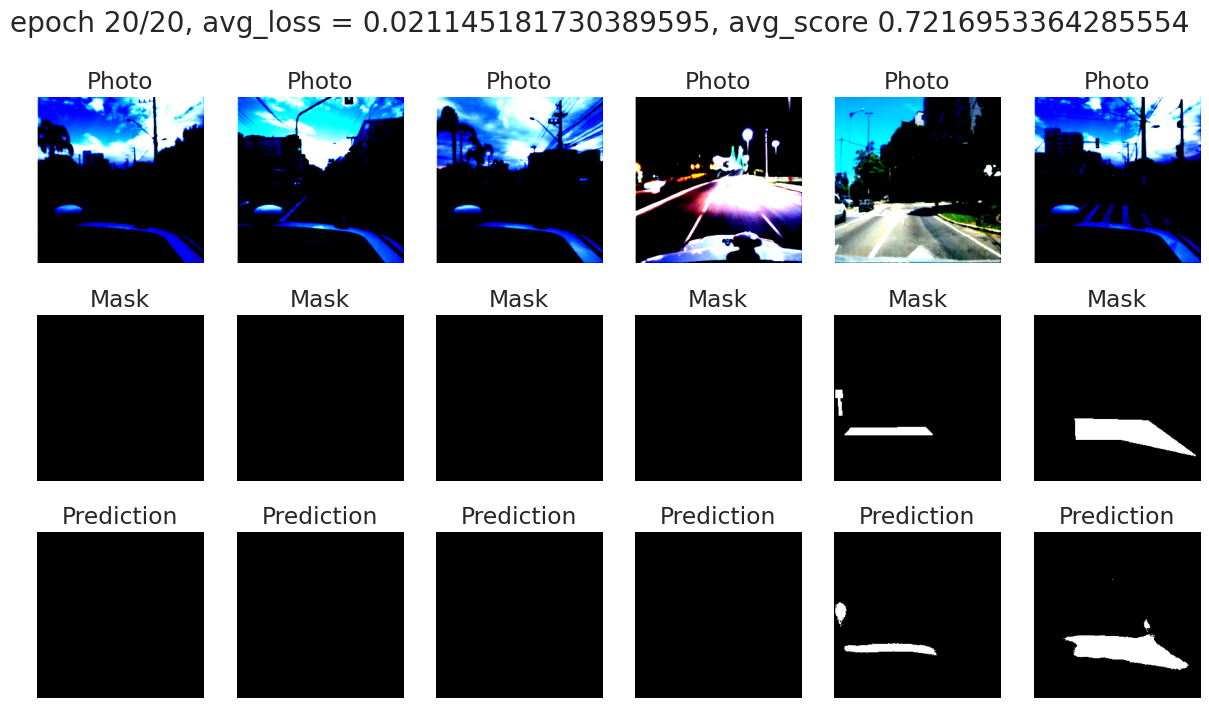

In [ ]:
optimizer_aug3 = torch.optim.Adam(model3.parameters(), lr=1e-4)


losses1_aug3, scores1_aug3 = train2("Unet_augm", model3, optimizer_aug3, loss_fn_aug3, iou_pytorch, max_epochs2, train_dataloader_augmented_for3)


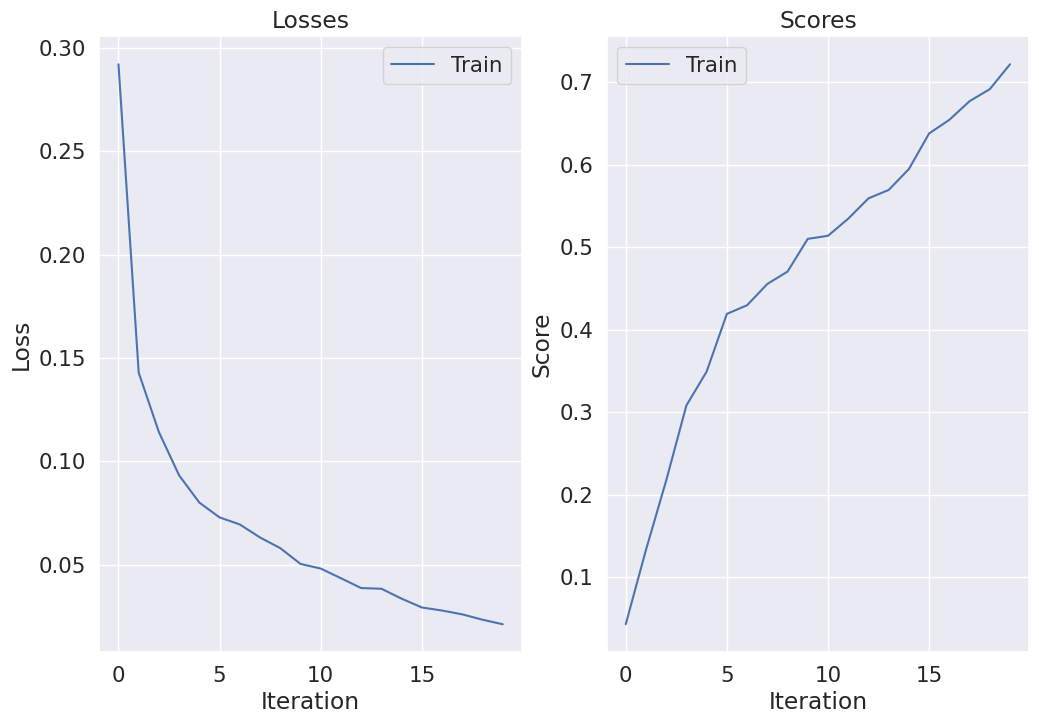

In [ ]:
plot_losses_scores2(losses1_aug3, scores1_aug3)

In [ ]:
print("Score train", score_mode(model3, iou_pytorch, train_dataloader, device))
print("Score val", score_mode(model3, iou_pytorch, val_dataloader, device))
print("Score test", score_mode(model3, iou_pytorch, test_dataloader, device))

Score train 0.7409718984907324
Score val 0.6016383290290832
Score test 0.5415679156780243


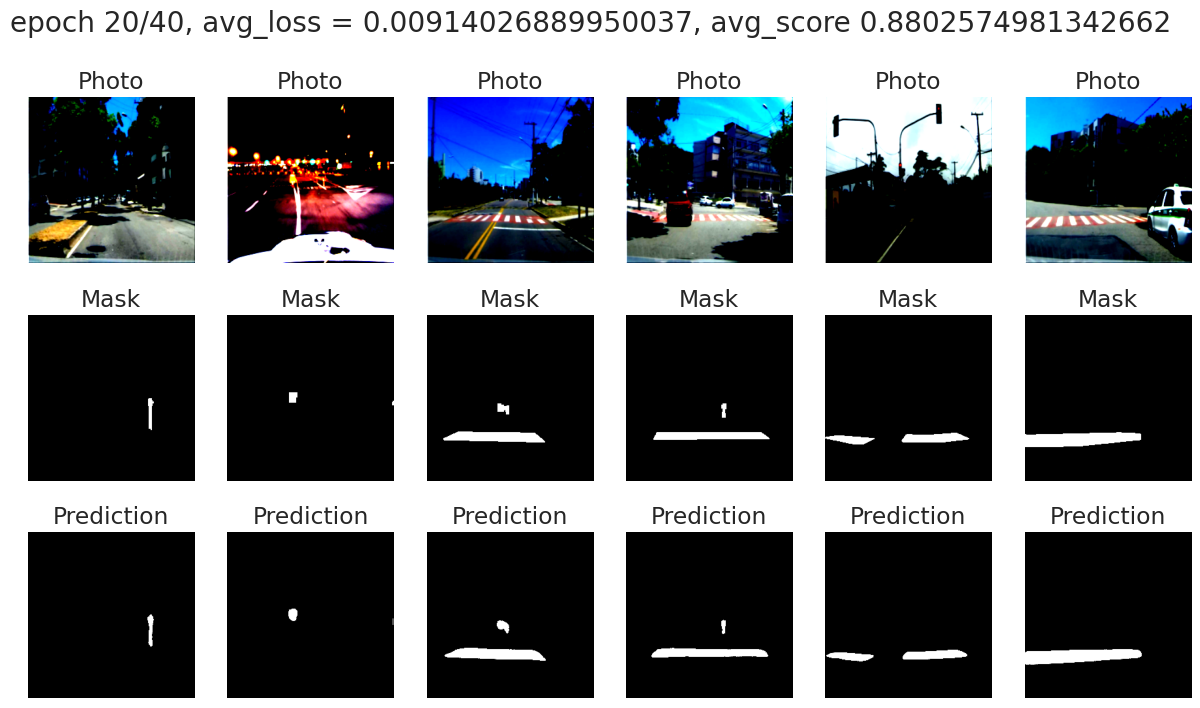

* Epoch 21/40


KeyboardInterrupt: 

In [ ]:
optimizer_aug32 = torch.optim.Adam(model3.parameters(), lr=1e-4)
max_epochs2 = 40

losses1_aug32, scores1_aug32 = train2("Unet_augm", model3, optimizer_aug32, loss_fn_aug3, iou_pytorch, max_epochs2, train_dataloader_augmented_for3)
# losses1_aug32, scores1_aug32 = train("Unet_augm", model3, optimizer_aug32, loss_fn_aug3, iou_pytorch, max_epochs2, aug_loaders_for3)

In [ ]:
print("Score train", score_mode(model3, iou_pytorch, train_dataloader, device))
print("Score val", score_mode(model3, iou_pytorch, val_dataloader, device))
print("Score test", score_mode(model3, iou_pytorch, test_dataloader, device))

Score train 0.8990907181393016
Score val 0.6798403978347778
Score test 0.5794187903404235


In [ ]:
torch.save(model3.state_dict(), '/content/model4.pth')

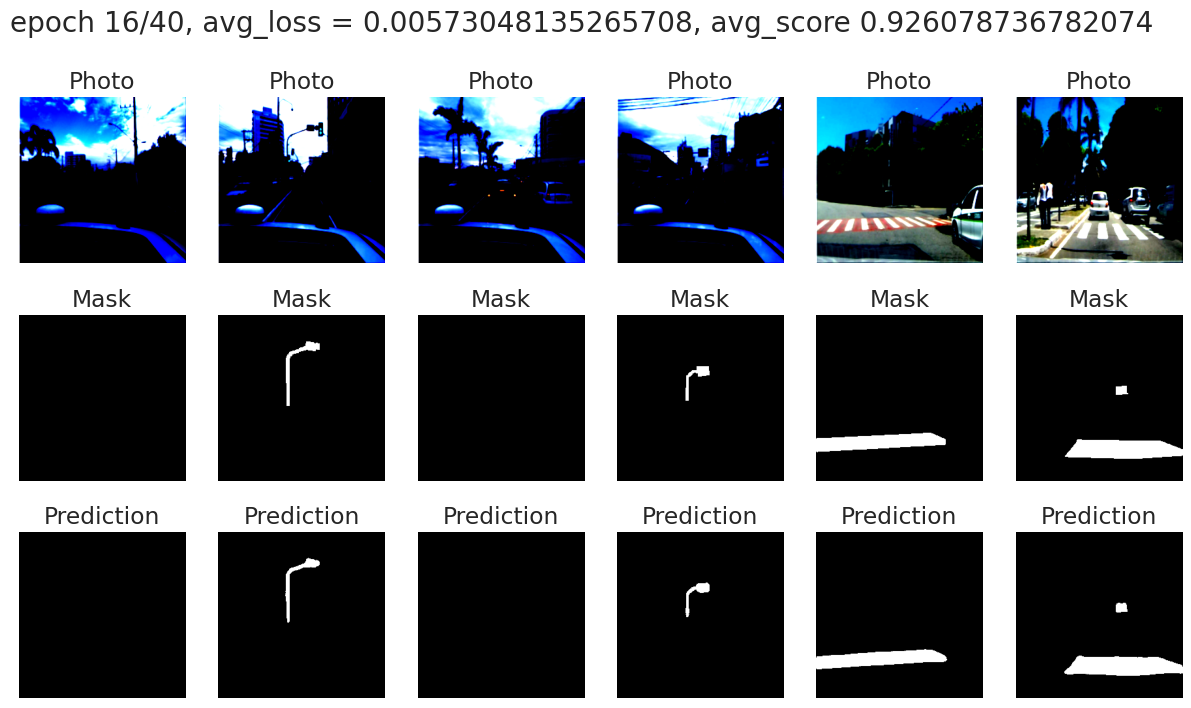

* Epoch 17/40


KeyboardInterrupt: 

In [ ]:
optimizer_aug32 = torch.optim.Adam(model3.parameters(), lr=1e-4)
max_epochs2 = 40

losses1_aug32, scores1_aug32 = train2("Unet_augm", model3, optimizer_aug32, loss_fn_aug3, iou_pytorch, max_epochs2, train_dataloader_augmented_for3)
# losses1_aug32, scores1_aug32 = train("Unet_augm", model3, optimizer_aug32, loss_fn_aug3, iou_pytorch, max_epochs2, aug_loaders_for3)

In [ ]:
print("Score train", score_mode(model3, iou_pytorch, train_dataloader, device))
print("Score val", score_mode(model3, iou_pytorch, val_dataloader, device))
print("Score test", score_mode(model3, iou_pytorch, test_dataloader, device))

Score train 0.8814849880608647
Score val 0.665742814540863
Score test 0.5762305498123169


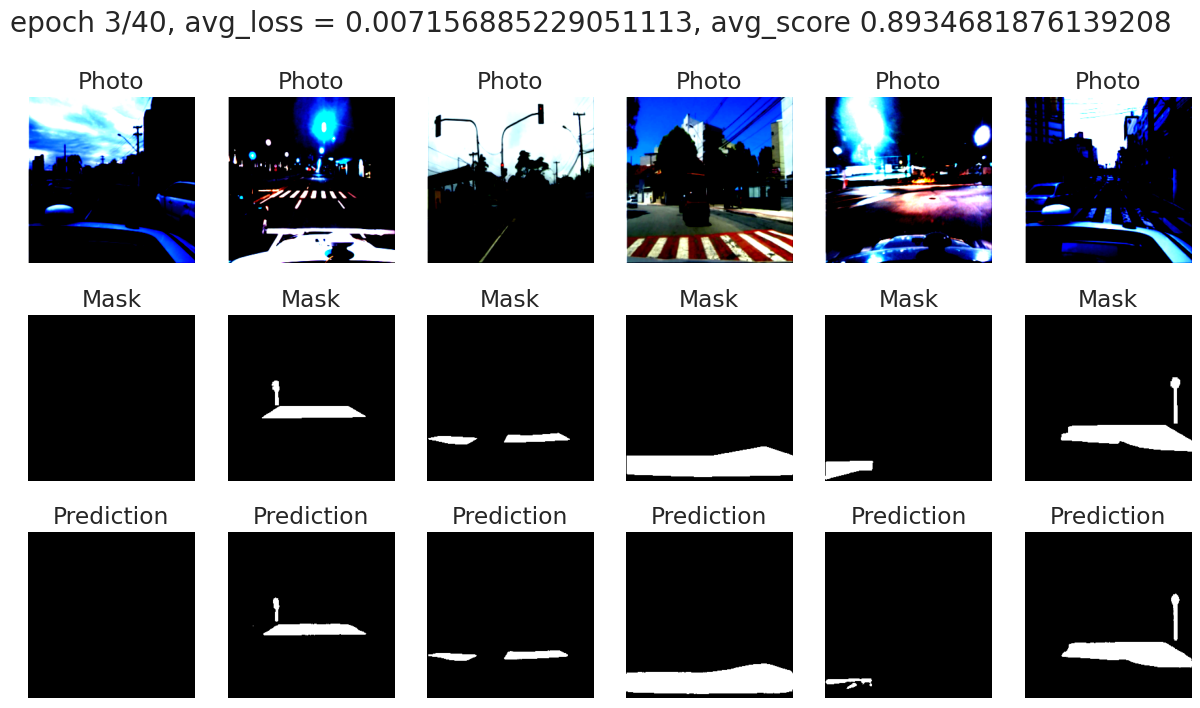

* Epoch 4/40


In [ ]:
optimizer_aug32 = torch.optim.Adam(model3.parameters(), lr=1e-4)
max_epochs2 = 40

losses1_aug32, scores1_aug32 = train2("Unet_augm", model3, optimizer_aug32, loss_fn_aug3, iou_pytorch, max_epochs2, train_dataloader_augmented_for3)
# losses1_aug32, scores1_aug32 = train("Unet_augm", model3, optimizer_aug32, loss_fn_aug3, iou_pytorch, max_epochs2, aug_loaders_for3)

In [ ]:
model3.load_state_dict(torch.load('/content/model4.pth'))

<All keys matched successfully>

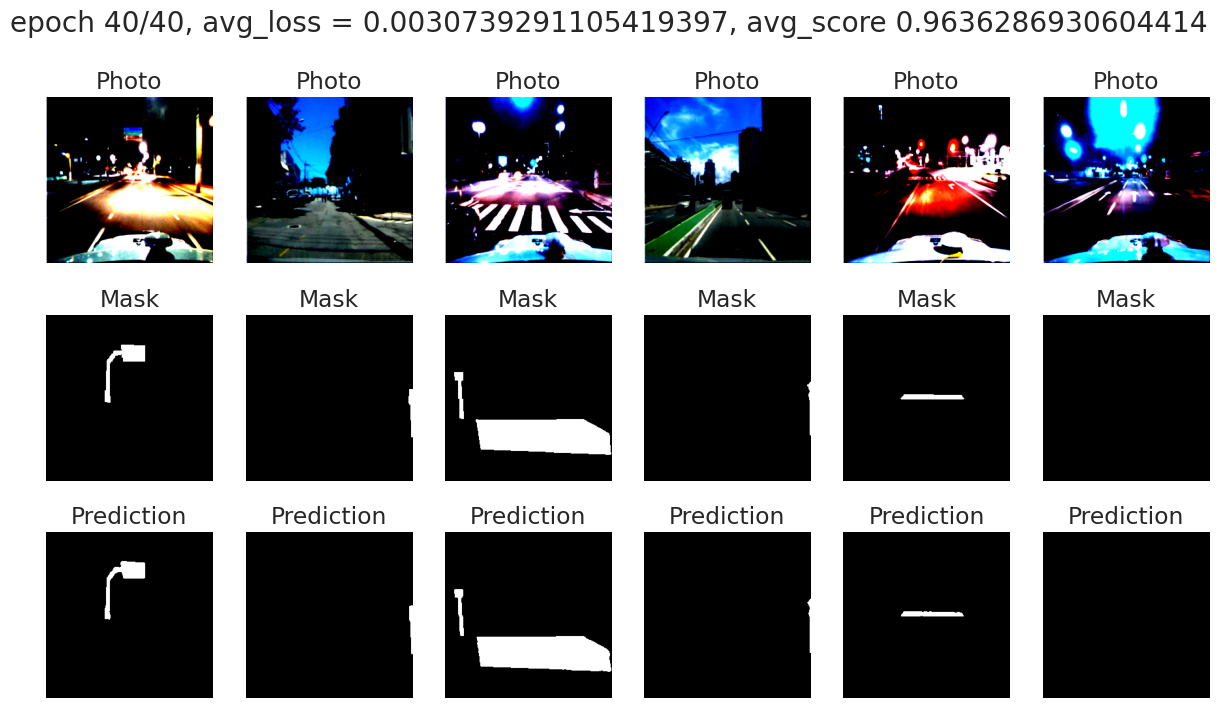

In [ ]:
optimizer_aug32 = torch.optim.Adam(model3.parameters(), lr=1e-4)
max_epochs2 = 40

losses1_aug32, scores1_aug32 = train2("Unet_augm", model3, optimizer_aug32, loss_fn_aug3, iou_pytorch, max_epochs2, train_dataloader_augmented_for3)
# losses1_aug32, scores1_aug32 = train("Unet_augm", model3, optimizer_aug32, loss_fn_aug3, iou_pytorch, max_epochs2, aug_loaders_for3)

In [ ]:
print("Score train", score_mode(model3, iou_pytorch, train_dataloader, device))
print("Score val", score_mode(model3, iou_pytorch, val_dataloader, device))
print("Score test", score_mode(model3, iou_pytorch, test_dataloader, device))

Score train 0.9640518210150979
Score val 0.6734488844871521
Score test 0.6068490624427795


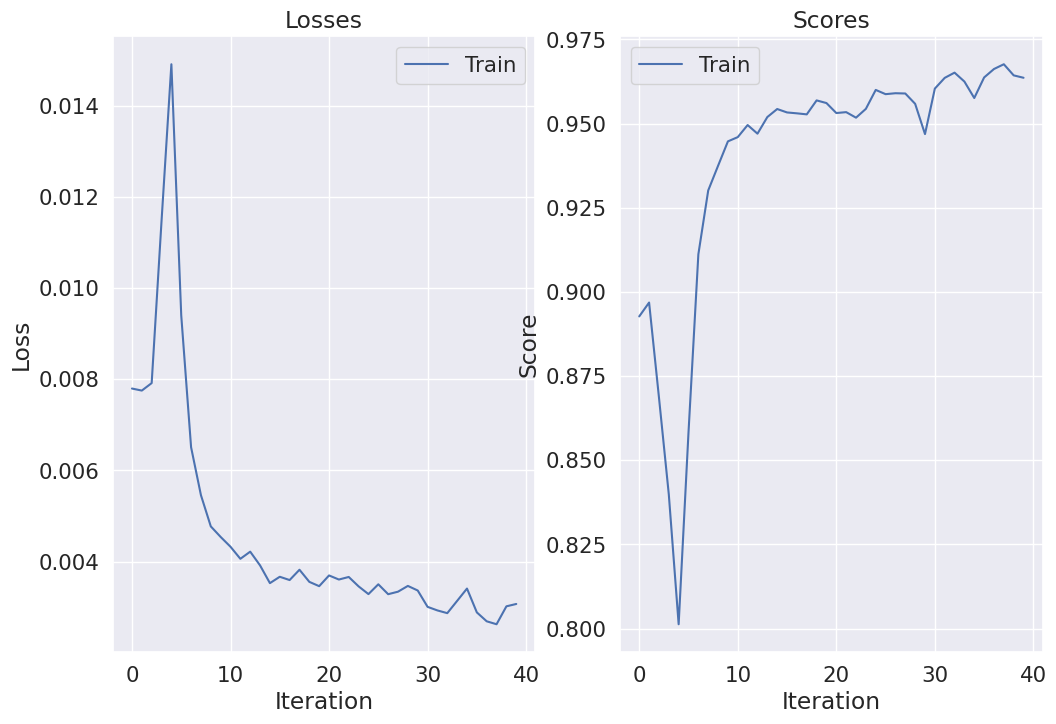

In [ ]:
plot_losses_scores2(losses1_aug32, scores1_aug32)

In [ ]:
torch.save(model3.state_dict(), '/content/model5.pth')

In [ ]:
class DiceBCELoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceBCELoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice_loss = 1 - (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        Dice_BCE = BCE + dice_loss

        return Dice_BCE

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):

        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)

        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)

        return 1 - dice

In [ ]:
model3 = UNet(input_channels=3, output_channels=1).to(device)
path_to_model = '/content/gdrive/MyDrive/model_parameters/model5.pth'
model3.load_state_dict(torch.load(path_to_model))
loss_fn_diceBCE = DiceBCELoss()

max_epochs2 = 20

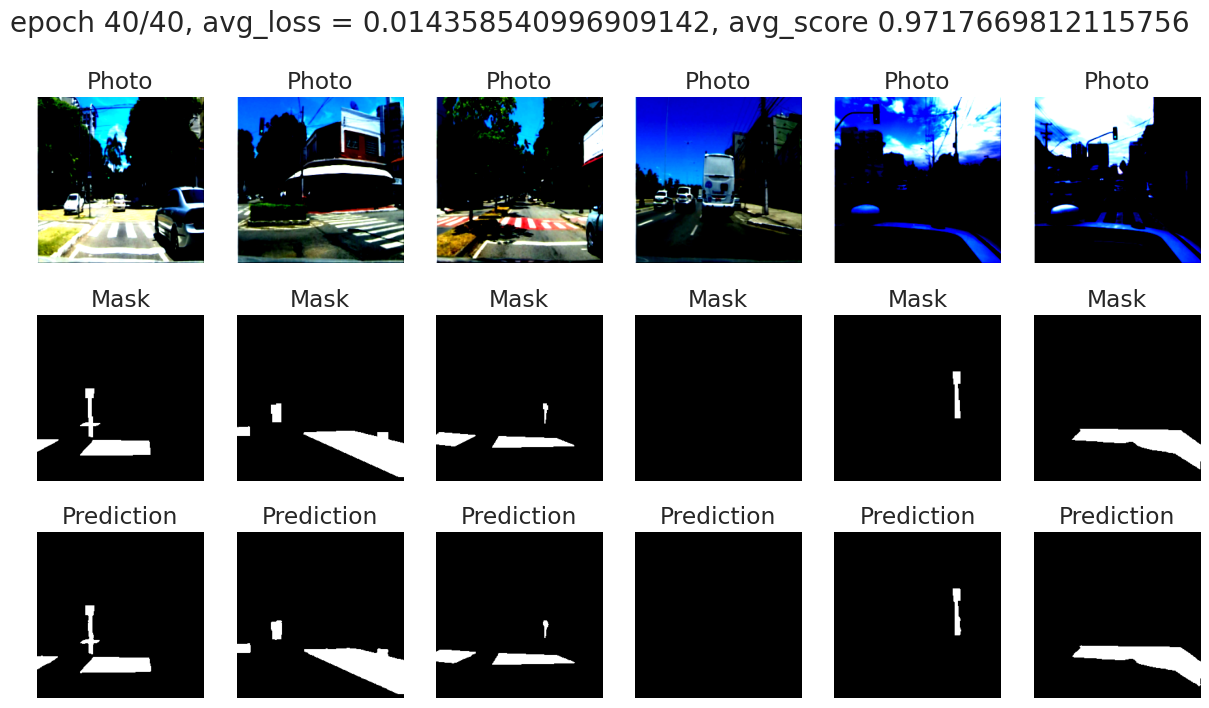

In [ ]:
optimizer_aug33 = torch.optim.Adam(model3.parameters(), lr=1e-4)
max_epochs2 = 40

losses1_aug33, scores1_aug33 = train2("Unet_augm", model3, optimizer_aug33, loss_fn_diceBCE, iou_pytorch, max_epochs2, train_dataloader_augmented4)
# losses1_aug32, scores1_aug32 = train("Unet_augm", model3, optimizer_aug32, loss_fn_aug3, iou_pytorch, max_epochs2, aug_loaders_for3)

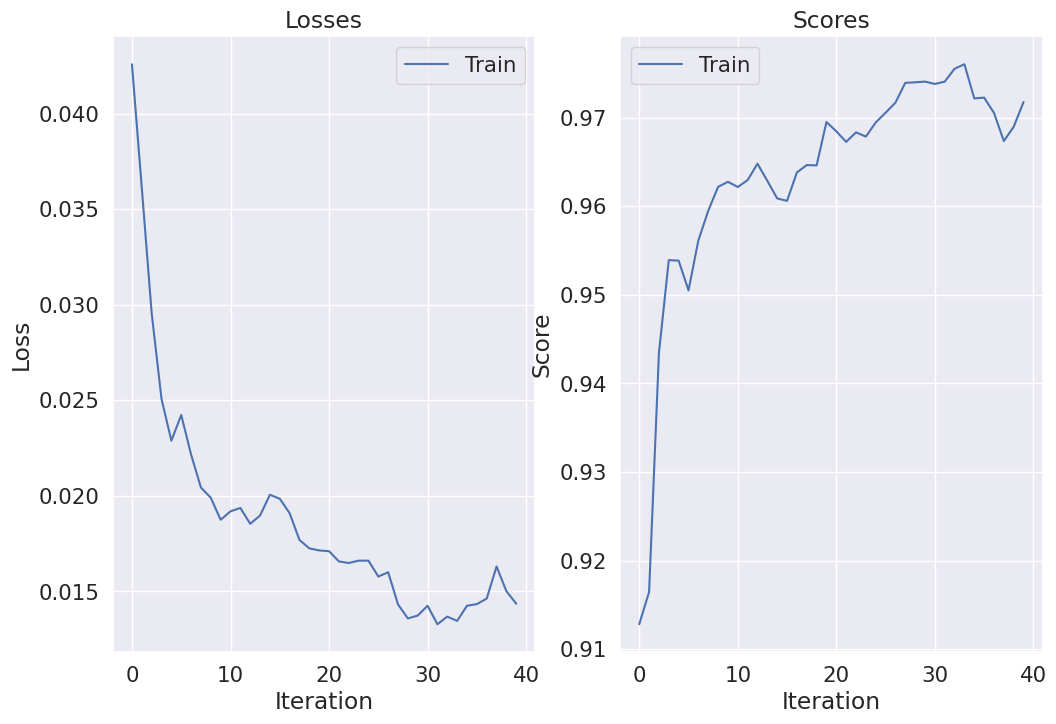

In [ ]:
plot_losses_scores2(losses1_aug33, scores1_aug33)

In [ ]:
print("Score train", score_mode(model3, iou_pytorch, train_dataloader, device))
print("Score val", score_mode(model3, iou_pytorch, val_dataloader, device))
print("Score test", score_mode(model3, iou_pytorch, test_dataloader, device))

Score train 0.9773532910780475
Score val 0.6968166947364807
Score test 0.6193709135055542


In [ ]:
torch.save(model3.state_dict(), '/content/gdrive/MyDrive/model_parameters/model6.pth')

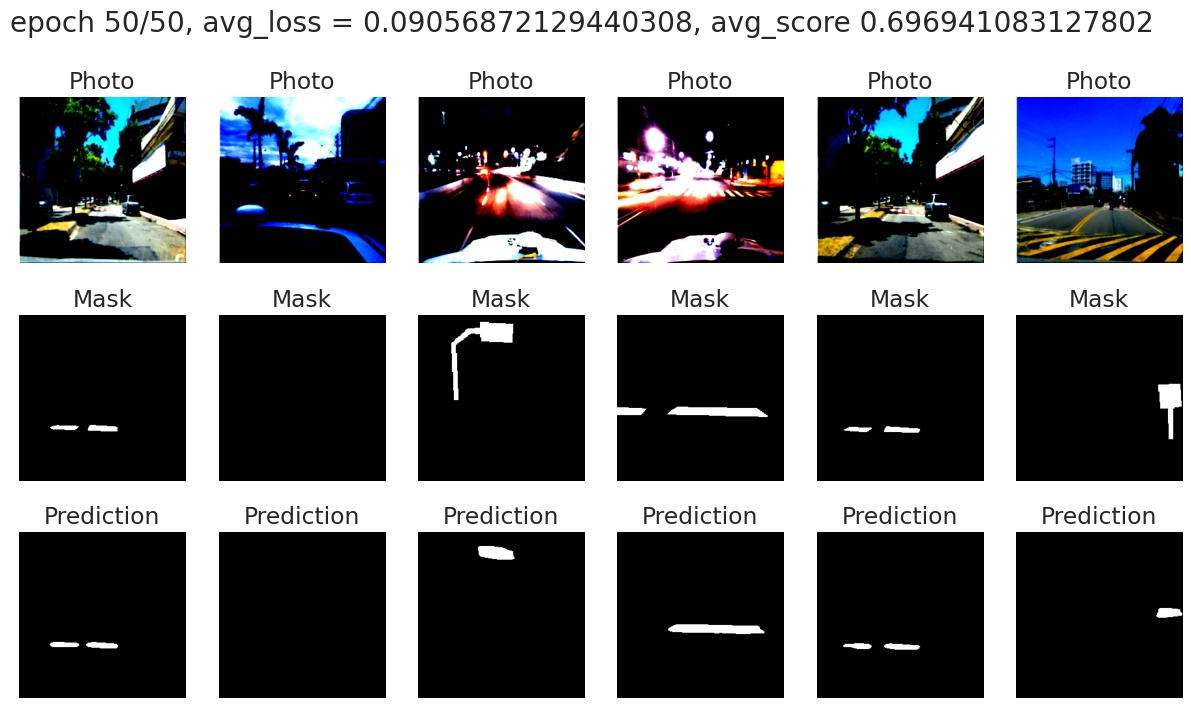

In [ ]:
model4 = UNet(input_channels=3, output_channels=1).to(device)
# path_to_model = '/content/gdrive/MyDrive/model_parameters/model5.pth'
# model3.load_state_dict(torch.load(path_to_model))
loss_fn_dice = DiceLoss()

optimizer41 = torch.optim.Adam(model4.parameters(), lr=1e-4)
max_epochs4 = 50

losses4_1, scores4_1 = train2("Unet_augm", model4, optimizer41, loss_fn_dice, iou_pytorch, max_epochs4, train_dataloader_augmented4)
# losses1_aug32, scores1_aug32 = train("Unet_augm", model4, optimizer41, loss_fn_dice, iou_pytorch, max_epochs4, train_dataloader_augmented4)

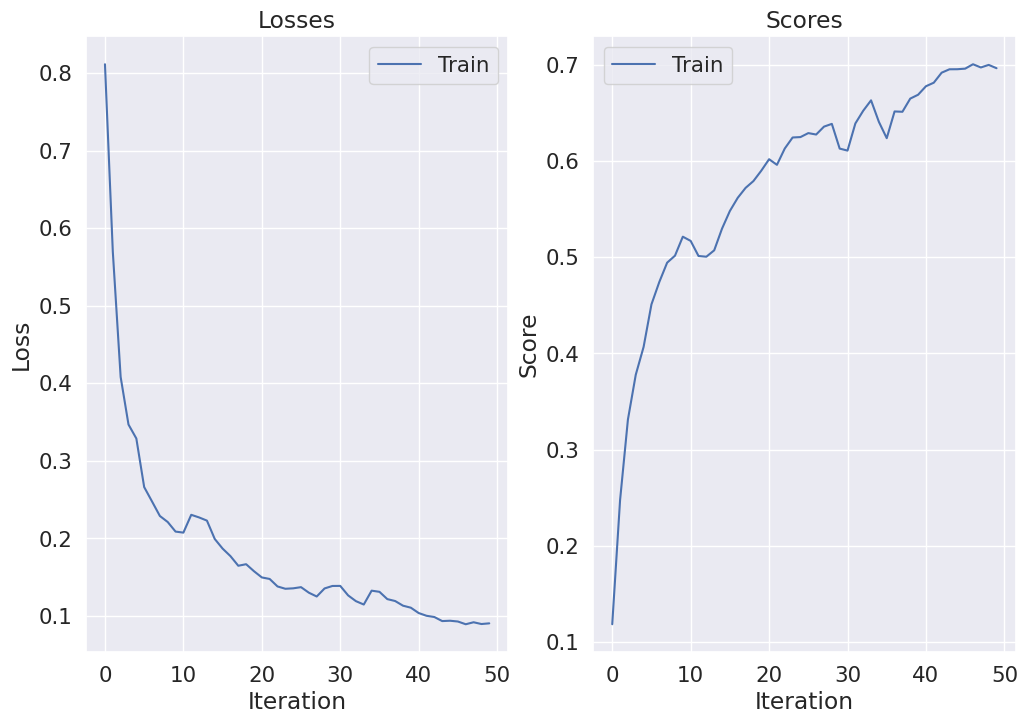

Score train 0.7070430544289676
Score val 0.6147886753082276
Score test 0.5601044654846191


In [ ]:
plot_losses_scores2(losses4_1, scores4_1)
print("Score train", score_mode(model4, iou_pytorch, train_dataloader, device))
print("Score val", score_mode(model4, iou_pytorch, val_dataloader, device))
print("Score test", score_mode(model4, iou_pytorch, test_dataloader, device))

In [ ]:
model5 = UNet(input_channels=3, output_channels=1).to(device)
path_to_model = '/content/gdrive/MyDrive/model_parameters/model6.pth'
model5.load_state_dict(torch.load(path_to_model))

<All keys matched successfully>

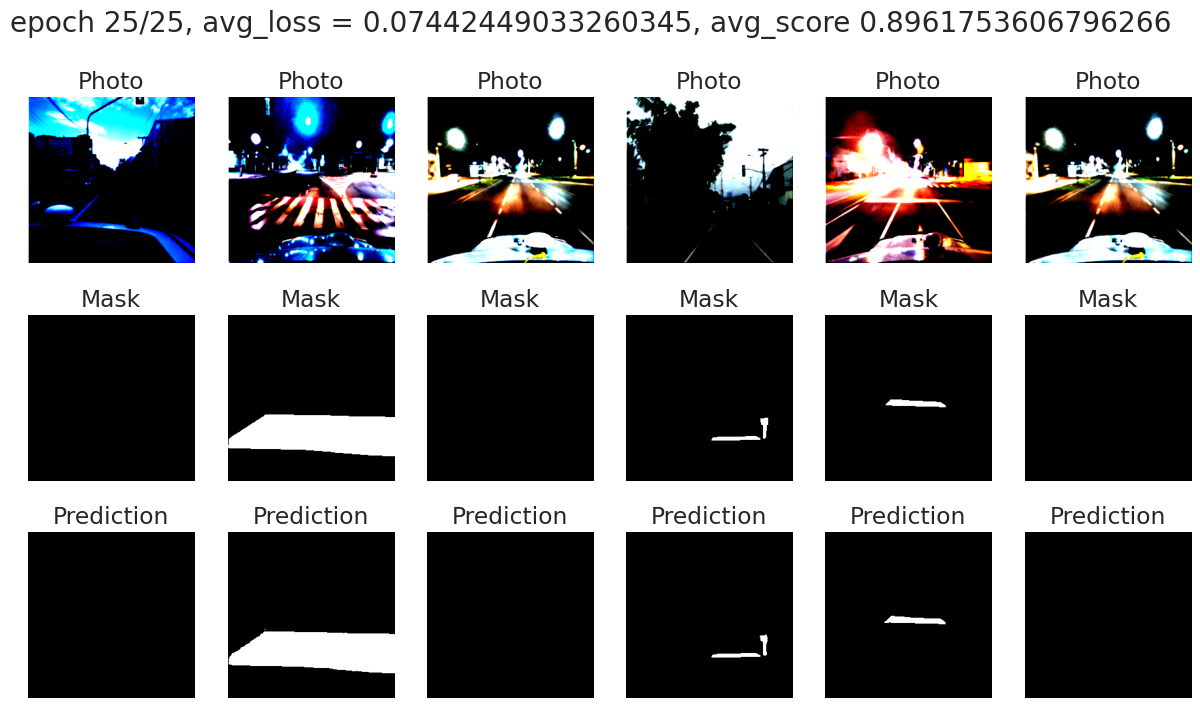

In [ ]:
# loss_fn_dice = DiceLoss()
loss_fn_BCEdice = DiceBCELoss()

optimizer51 = torch.optim.Adam(model5.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer51, 'min')
max_epochs = 25

# losses5_1, scores5_1 = train("Unet_augm", model4, optimizer42, loss_fn_BCEdice, iou_pytorch, max_epochs4, aug_loaders4)
# losses4_2, scores4_2 = train2("Unet_augm", model4, optimizer42, loss_fn_dice, iou_pytorch, max_epochs4, train_dataloader_augmented4)
losses5_1, scores5_1 = train_sch("Unet_augm", model5, optimizer51, loss_fn_BCEdice, iou_pytorch, max_epochs, aug_loaders4, scheduler)

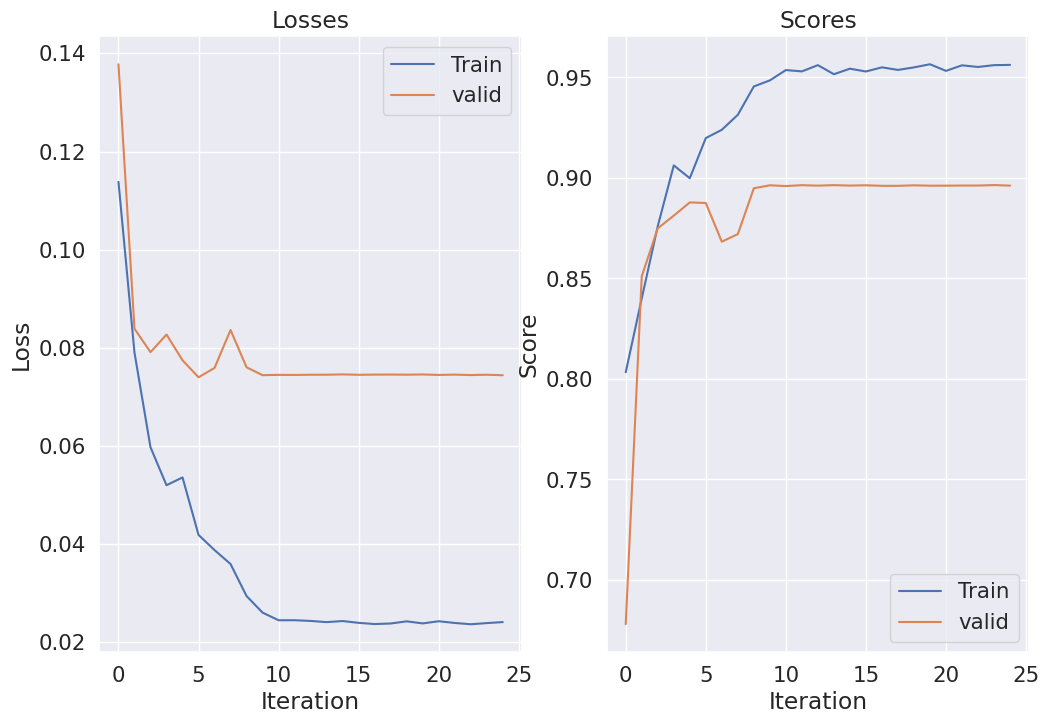

Score train 0.9564337784593756
Score val 0.8961753606796266
Score test 0.8877183794975281


In [ ]:
plot_losses_scores(losses5_1, scores5_1)
print("Score train", score_mode(model5, iou_pytorch, train_dataloader, device))
print("Score val", score_mode(model5, iou_pytorch, val_dataloader, device))
print("Score test", score_mode(model5, iou_pytorch, test_dataloader, device))

In [ ]:
torch.save(model5.state_dict(), '/content/gdrive/MyDrive/model_parameters/model_0.88iou.pth')

### Описание всего процесса обучение:
1. На первом этапе модель Unet была обучена на входном датасете с достижением IoU 0.625.
2. Затем, сохранив параметры первой модели, ее параметры были загружены в новую модель. Данные были аунментированы с помощью отражения по вертикали, поворотов, случайного выбора участка картинки и изменения значений пикселей для удовлетворения стандартным предложенным средним и дисперсиям. Попробовал использовать другие функции потерь Dice и BCE+Dice. BCE+Dice должен по идее учитывать несбалансированность данных и метрику IoU. Несколько раз запускал обучение, сохранял веса моделей для нового запуска. Score 0.65 не был достигнут
3. Поэтому дальше в добавок к loss BCE+Dice был применен scheduler ReduceLROnPlateau, который уменьшает lr, если loss на valid выборке не изменется, который дал сильный скачок в score до IoU = 0.887 на тестировании.

# Задача 8. Сравнение результатов обучения моделей

Ссылка на модель UNet,  обученную на входном дадасете:
https://drive.google.com/file/d/13dvds5ctNM-mUam3yox1mogCu1nRCtHw/view?usp=sharing


Ссылка на модель UNet,  обученную на входном аугментированном дадасете:
https://drive.google.com/file/d/1p8FJA-sM-CXrsqvhV6KzYysxe8ba1UZ9/view?usp=sharing

In [ ]:
model_before_aug= UNet(input_channels=3, output_channels=1).to(device)
model_before_aug.load_state_dict(torch.load('/content/gdrive/MyDrive/model_parameters/model.pth'))

model_after_aug= UNet(input_channels=3, output_channels=1).to(device)
model_after_aug.load_state_dict(torch.load('/content/gdrive/MyDrive/model_parameters/model_0.88iou.pth'))

<All keys matched successfully>

Тестирование обученной модели Unet на входном датасете

In [ ]:
print("Score train", score_mode(model_before_aug, iou_pytorch, train_dataloader, device))
print("Score val", score_mode(model_before_aug, iou_pytorch, val_dataloader, device))
print("Score test", score_mode(model_before_aug, iou_pytorch, test_dataloader, device))

Score train 0.9357662390578877
Score val 0.7041656136512757
Score test 0.6257184624671936


In [ ]:
print("Score train", score_mode(model_after_aug, iou_pytorch, train_dataloader, device))
print("Score val", score_mode(model_after_aug, iou_pytorch, val_dataloader, device))
print("Score test", score_mode(model_after_aug, iou_pytorch, test_dataloader, device))

Score train 0.9769744764674795
Score val 0.847960102558136
Score test 0.8336136817932129


Результаты тестирования финальной модели отличаются от тех, которые были во время обучения. Значит, на его обучении seed не был зафиксирован

# Отправка результатов

Поздравляем, вы почти дошли до конца! Осталось все проверить и отправить работу.

Пожалуйста, проверьте, что ваш Colab Notebook удовлетворяет следующим требованиям:
1. Работа выполенена самостоятельно, а в позаимствованном коде вы разобрались. Хорошими практиками являются:
  - наличие ссылок на ресурсы откуда был взят код,
  - наличие комментариев в коде.
2. Ваши выводы обоснованы.
3. Код запускаем, результаты воспроизводимы. Например, если вы несколько раз обучаете, то сделайте дополнительную ячейку с еще одним обучением, а не запускайте одну и ту же несколько раз. Иначе, повторный запуск всего кода даст другие результаты.
Если данные берутся с вашего гугл-диска, то должна быть доступна ссылка на эти данные.
4. Colab Notebook должен содержать результаты выполнения кода в ячейках.
5. Общая структура данного Colab Notebook сохранена.


Для сдачи задания расшарьте colab notebook по ссылку и отправьте полученную ссылку через [Google Form](https://forms.gle/AFpnYMKw4kKb1rUF7).

Если хотите продолжить работу, сделайте копию. Успели ли вы до дедлайна будет проверяться по дате изменения ноутбука.